# Домашние задания по математической статистике

### Гаварина Светлана, СКБ-171
---

# Домашнее задание 2.
# Основные понятия математической статистики


## 1. Распределение Пуассона

---
## 1.1 Моделирование выбранных случайных величин

In [69]:
import random
import numpy as np
import math

# функция генерации выборки
def rand_Pois(lamb, n):
    nums = []
    for i in range(n):
        p = math.exp(-lamb)
        sp = 0
        sp += p
        u = random.uniform(0,1)
        j = 0
        while u > sp:
            j += 1         # p_j
            p *= lamb / j  # p_j / p_j-1 = lamb / j
            sp += p
        nums.append(j)
    return nums

#Функция вероятности (закон распределения)
def f_Pois(x, lamb):
    return math.exp(-lamb) * lamb ** x / math.factorial(x)

#Функция распределения
def F_Pois(x, lamb):
    s = 0
    for i in range(x - 1):
        s += math.exp(-lamb) * lamb ** i / math.factorial(i)
    return s

#### Пусть $\lambda = 3$.

In [47]:
lamb = 3

pois5 = [] # Выборки объемом 5
for i in range(5):
    pois5.append(rand_Pois(lamb, 5))
    
pois10 = [] # Выборки объемом 10
for i in range(5):
    pois10.append(rand_Pois(lamb, 10))
    
pois100 = [] # Выборки объемом 100
for i in range(5):
    pois100.append(rand_Pois(lamb, 100))
    
pois1000 = [] # Выборки объемом 1000
for i in range(5):
    pois1000.append(rand_Pois(lamb, 1000))

pois105 = [] # Выборки объемом 10 ** 5
for i in range(5):
    pois105.append(rand_Pois(lamb, 10 ** 5))
    
print('Выборки объемом 5:', *pois5, sep='\n')
print('Выборки объемом 10:', *pois10, sep='\n')

Выборки объемом 5:
[0, 3, 4, 2, 1]
[2, 2, 3, 3, 0]
[5, 3, 3, 2, 3]
[2, 4, 8, 3, 3]
[4, 3, 4, 1, 2]
Выборки объемом 10:
[1, 1, 4, 5, 5, 1, 4, 4, 3, 4]
[1, 2, 4, 1, 3, 2, 7, 6, 10, 4]
[2, 4, 5, 3, 1, 2, 2, 0, 5, 6]
[7, 8, 0, 2, 2, 5, 6, 3, 4, 1]
[3, 2, 4, 3, 3, 2, 5, 0, 2, 4]


---
## 1.2. Построение эмпирической функции распределения


$\stackrel{\wedge}{F_n}(x) = \dfrac{\sum\limits_{i=1}^{n}I(x_i < x)}{n}$

Функции для дискретной и для непрерывной величины будут различаться лишь тем, что в первом случае x будут только целыми.

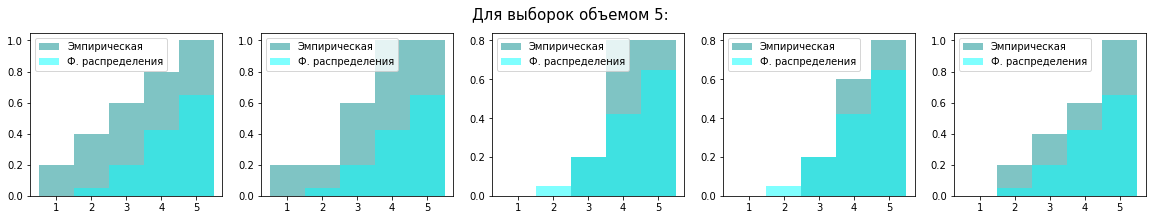

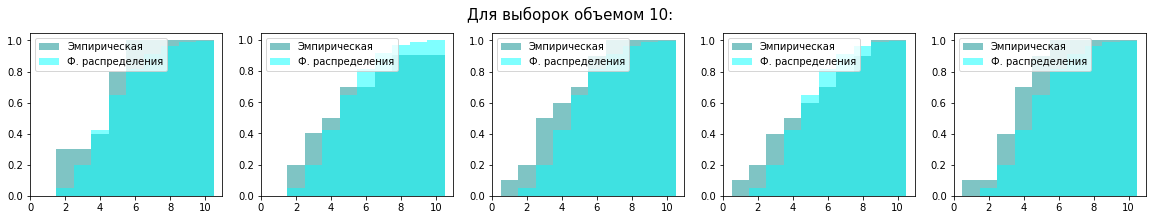

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

# nums - выборка
# n - размер выборки
# is_discr - флаг дискретного/непрерывного распределения

def emp(nums, n, is_discr):
    nums_s = sorted(nums)
    xx = []
    yy = []
    if is_discr:
        i_range = range(1, n + 1)
    else:
        i_range = np.linspace(0, n / (n / 10), 110)
    temp_ind = 0
    s = 0
#     for i in i_range: -- старая версия. Работает на несколько порядков медленнее
#         xx.append(i)
#         yy.append(sum(1 for x in nums if x < i) / n)
    for i in i_range:
        xx.append(i)
        while temp_ind < len(nums_s) and nums_s[temp_ind] < i:
            s += 1
            temp_ind += 1
#             print(temp_ind, i)
        yy.append(s / n)
    
    return xx, yy

# pois -- список выборок объемом n
def hists_pois(pois, n):
    plt.figure(figsize=(20, 3))
    plt.suptitle('Для выборок объемом ' + str(n) + ':', fontsize=15, y=1.)
    cnt = 151
    for p in pois:
        xx, yy = emp(p, n, True)
        y_f = list(map(lambda i: F_Pois(i, 3), xx))
        plt.subplot(cnt)
        plt.bar(xx, yy, alpha = 0.5, color = 'DarkCyan', align = 'center', width=1, label = 'Эмпирическая')
        plt.bar(xx, y_f, alpha = 0.5, color = 'Cyan', align = 'center', width=1, label = 'Ф. распределения')
        plt.legend(loc="upper left")
        cnt += 1

hists_pois(pois5, 5)
hists_pois(pois10, 10)

Таким образом, очевидно, что чем больше объем выборки, тем точнее приближение эмпирической функции к функции распределения. Для наглядности представим график для выборки объемом 100:

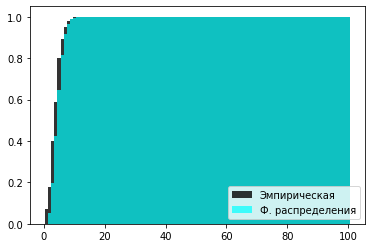

In [49]:
xx, yy = emp(pois100[0], 100, True)
_, ax = plt.subplots()
y_f = list(map(lambda i: F_Pois(i, 3), xx))
ax.bar(xx, yy, alpha = 0.8, color = 'Black', align = 'center', width=1, label = 'Эмпирическая')
ax.bar(xx, y_f, alpha = 0.7, color = 'Cyan', align = 'center', width=1, label = 'Ф. распределения')
# ax.plot(xx, yy)
# ax.plot(xx, y_f)
ax.legend(loc="lower right")

#### Нахождение точной верхней границы разности каждой пары эмпирических функций распределения.

Берутся два набора x и y, по одному для каждой эмпирической функции для выборке в паре. Точки x, согласно алгоритму нахождения эмпирической функции распределения, для них совпадают. Для каждого x ищутся соответствующие y в каждом из наборов, берется модуль разности для них. Последним шагом ищется максимум этих модулей.

In [117]:
import itertools
import tqdm

def high_of_diff_old(combs, n, is_diskr):
    i = 1
    ans = []
#     for comb in tqdm.tqdm(combs):
    for comb in combs:
        x1, y1 = emp(comb[0], n, is_diskr)
        x2, y2 = emp(comb[1], n, is_diskr)
        yy = []
        for x in x1:
            ind = x1.index(x)
            yy.append(abs(y1[ind] - y2[ind]))
        ans.append(max(yy))
#         print('Для комбинации выборок #', i, 'верхняя граница разности равна', max(yy))
        i += 1
    return np.round(ans, 5)

##### 1. Для выборок объемом n = 5

In [120]:
combs5 = list(itertools.combinations(pois5, 2))

print(high_of_diff(combs5, 5, True))

[0.2 0.4 0.4 0.2 0.4 0.4 0.4 0.2 0.2 0.2]


##### 2. Для выборок объемом n = 10

In [51]:
combs10 = list(itertools.combinations(pois10, 2))

print(high_of_diff(combs10, 10, True))

[0.3 0.2 0.3 0.3 0.2 0.1 0.3 0.2 0.2 0.3]


##### 3. Для выборок объемом n = 100

In [52]:
# %%time
combs100 = list(itertools.combinations(pois100, 2))

print(high_of_diff(combs100, 100, True))

[0.04 0.08 0.07 0.06 0.06 0.07 0.04 0.13 0.06 0.08]


##### 4. Для выборок объемом n = 1000

In [102]:
# %%time
combs1000 = list(itertools.combinations(pois1000, 2))

print(high_of_diff(combs1000, 1000, True))

[0.019 0.024 0.03  0.031 0.02  0.021 0.012 0.022 0.025 0.023]


##### 5. Для выборок объемом n = 10 ** 5

In [121]:
%%time
combs105 = list(itertools.combinations(pois105, 2))

print(high_of_diff(combs105, 10 ** 5, True))

[0.00271 0.00184 0.00233 0.00318 0.00158 0.00224 0.00415 0.00132 0.00334
 0.00394]
Wall time: 13min 15s


---
## 1.3 Построение вариационного ряда выборки

In [55]:
var_list_5 = []
for i in pois5:
    var_list_5.append(sorted(i))
print('Вариационные ряды для выборок объема 5:', *var_list_5, sep='\n')
print()

var_list_10 = []
for i in pois10:
    var_list_10.append(sorted(i))
print('Вариационные ряды для выборок объема 10:', *var_list_10, sep='\n')

var_list_100 = []
for i in pois100:
    var_list_100.append(sorted(i))
    
var_list_1000 = []
for i in pois1000:
    var_list_1000.append(sorted(i))
    
var_list_105 = []
for i in pois105:
    var_list_105.append(sorted(i))

Вариационные ряды для выборок объема 5:
[0, 1, 2, 3, 4]
[0, 2, 2, 3, 3]
[2, 3, 3, 3, 5]
[2, 3, 3, 4, 8]
[1, 2, 3, 4, 4]

Вариационные ряды для выборок объема 10:
[1, 1, 1, 3, 4, 4, 4, 4, 5, 5]
[1, 1, 2, 2, 3, 4, 4, 6, 7, 10]
[0, 1, 2, 2, 2, 3, 4, 5, 5, 6]
[0, 1, 2, 2, 3, 4, 5, 6, 7, 8]
[0, 2, 2, 2, 3, 3, 3, 4, 4, 5]


#### Найти выборочную квантиль уровня 0.1, 0.5, 0.7

Из функции нахождения эмпирической функции распределения получаем список x и y. Если искомая квантиль находится в списке y, то необходимо найти соответствующую ей x. В противном случае находится промежуток, в котором находится квантиль, и найти среднее в нем.

В случае, если квантиль меньше самого малого из y, возвращается 0.

В случае, если квантиль больше самого большого из у, возвращается x, соответствующее максимальному у.

In [57]:
import scipy.stats.mstats as ssm
import pandas as pd

def find_kvant(kvant, emp_f):
    xx, yy = emp_f
    if kvant in yy:
        return xx[yy.index(kvant)]
    else:
        ind_y = 0 # индекс правого конца промежутка, в котором находится квантиль
        if kvant < min(yy):
            return 0
        elif kvant > max(yy):
            return xx[yy.index(max(yy))]
        else:
            while ind_y < len(yy) and yy[ind_y] < kvant:
                ind_y += 1
            if ind_y:
                return (xx[ind_y] + xx[ind_y - 1]) / 2
            else:
                return (xx[0] / 2)

    
kvs = [0.1, 0.5, 0.7] 

def print_quants(kv, distr, n, is_diskr):
    print('Выборки объемом ', n, ':', sep='')
    my_quants = []
    sp_quants = []
    for kv in kvs:
        quants = []
        quants_tru = []
        for d in distr:
            quants.append(np.round(find_kvant(kv, emp(d, n, is_diskr)), 3))
            quants_tru.append(np.round(*ssm.mquantiles(d, kv), 3))
        my_quants.append(quants)
        sp_quants.append(quants_tru)
    data = np.array([['', my_quants[0], sp_quants[0]], ['', my_quants[1], sp_quants[1]], ['', my_quants[2], sp_quants[2]]])
    pd.options.display.expand_frame_repr = False
    print(pd.DataFrame(data, columns = ['', 'Представленная функция', 'Из пакета scipy'], index = [0.1, 0.5, 0.7]))

print_quants(kvs, pois5, 5, True)
print()
print_quants(kvs, pois10, 10, True)
print()
print_quants(kvs, pois100, 100, True)
print()
print_quants(kvs, pois1000, 1000, True)
print()
print_quants(kvs, pois105, 10 ** 5, True)

Выборки объемом 5:
          Представленная функция               Из пакета scipy
0.1        [0, 0, 2.5, 2.5, 1.5]     [0.0, 0.0, 2.0, 2.0, 1.0]
0.5    [2.5, 2.5, 3.5, 3.5, 3.5]     [2.0, 2.0, 3.0, 3.0, 3.0]
0.7    [3.5, 3.5, 3.5, 4.5, 4.5]  [3.04, 3.0, 3.08, 4.16, 4.0]

Выборки объемом 10:
      Представленная функция                Из пакета scipy
0.1      [1.5, 1.5, 1, 1, 1]   [1.0, 1.0, 0.42, 0.42, 0.84]
0.5      [4.5, 4, 3, 4, 3.5]      [4.0, 3.5, 2.5, 3.5, 3.0]
0.7        [4.5, 5, 5, 6, 4]  [4.0, 5.08, 4.54, 5.54, 3.54]

Выборки объемом 100:
          Представленная функция            Из пакета scipy
0.1    [1.5, 1.5, 1.5, 1.5, 1.5]  [1.0, 1.0, 1.0, 1.0, 1.0]
0.5    [3.5, 3.5, 3.5, 3.5, 3.5]  [3.0, 3.0, 3.0, 3.0, 3.0]
0.7    [4.5, 4.5, 4.5, 4.5, 4.5]  [4.0, 4.0, 4.0, 4.0, 4.0]

Выборки объемом 1000:
          Представленная функция            Из пакета scipy
0.1    [1.5, 1.5, 1.5, 1.5, 1.5]  [1.0, 1.0, 1.0, 1.0, 1.0]
0.5    [3.5, 3.5, 3.5, 3.5, 3.5]  [3.0, 3.0, 3.0, 3.0, 3.0]
0.7

---
## 1.4 Построение полигона частот

In [96]:
def freq_polygons(var_list, n):
    plt.figure(figsize=(20, 3))
    
    plt.suptitle('Для выборок объемом ' + str(n) + ':', fontsize=15, y=1.)
    cnt = 151
    for v in var_list:
        yy = []
        x_1 = range(max(v) + 1)
        y_1 = list(map(lambda x: f_Pois(x, 3), x_1))
       
        for x in v:
            yy.append(v.count(x) / n) # писать свой count бесполезно по оптимизации
        plt.subplot(cnt)
        plt.plot(v, yy, label = 'Полигон')
        plt.plot(x_1, y_1, label = 'Ф.вероятности')
        plt.legend(loc="upper right")
        cnt += 1

Wall time: 8min 39s


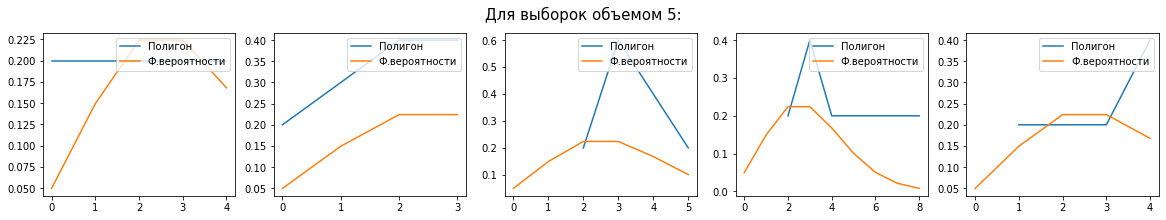

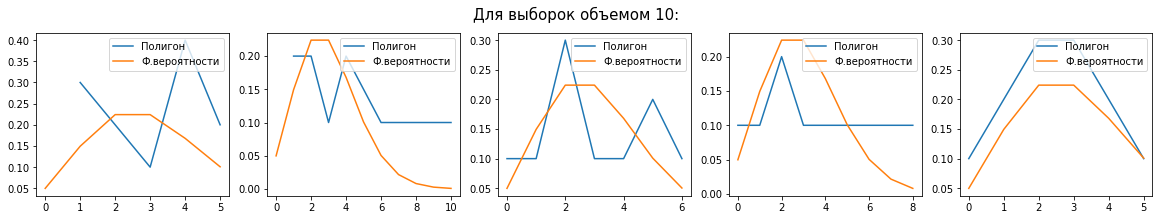

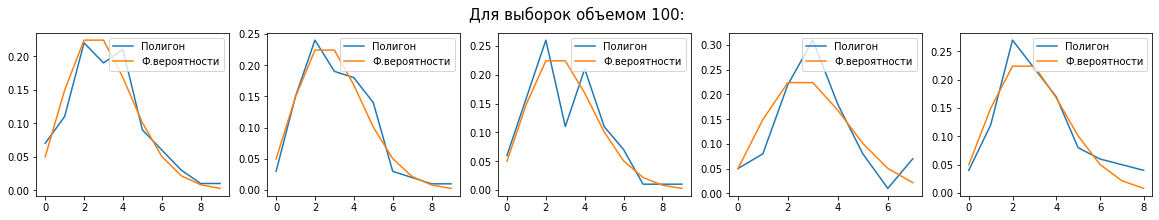

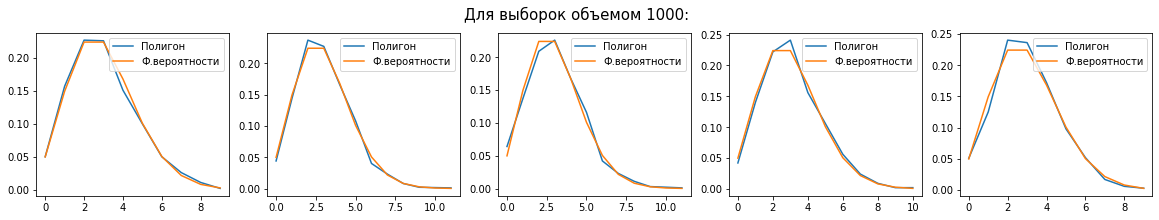

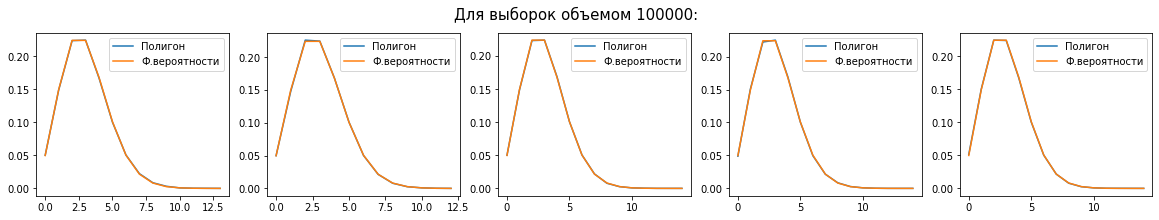

In [143]:
%%time
freq_polygons(var_list_5, 5)
freq_polygons(var_list_10, 10)
freq_polygons(var_list_100, 100)
freq_polygons(var_list_1000, 1000)
freq_polygons(var_list_105, 10 ** 5)

---
---
---
# 2. Распределение Рэлея

---
## 2.1 Моделирование выбранных случайных величин

In [66]:
def inv_f_Rayl(sigma, u):
    return sigma * math.sqrt(-2 * math.log(u))

# Функция генерации выборки
def rand_Rayl(sigma, n):
    nums = []
    for i in range(n):
        u = random.uniform(0, 1)
        nums.append(inv_f_Rayl(sigma, u))
    return nums

# Функция плотности распределения
def f_Rayl(x, sigma):
    return np.exp(-(x ** 2) / (2 * sigma ** 2)) * (x / (sigma ** 2))

# Функция распределения
def F_Rayl(x, sigma):
    return 1 - np.exp(-(x ** 2) / (2 * sigma ** 2))

#### Пусть $\sigma=3$:

In [67]:
sigma = 3

rayl5 = [] # Выборки объемом 5
for i in range(5):
    rayl5.append(rand_Rayl(sigma, 5))
    
rayl10 = [] # Выборки объемом 10
for i in range(5):
    rayl10.append(rand_Rayl(sigma, 10))
    
rayl100 = [] # Выборки объемом 100
for i in range(5):
    rayl100.append(rand_Rayl(sigma, 100))
    
rayl1000 = [] # Выборки объемом 1000
for i in range(5):
    rayl1000.append(rand_Rayl(sigma, 1000))

rayl105 = [] # Выборки объемом 10 ** 5
for i in range(5):
    rayl105.append(rand_Rayl(sigma, 10 ** 5))
    
print('Выборки объемом 5:', *rayl5, sep='\n')
print()
print('Выборки объемом 10:', *rayl10, sep='\n')

Выборки объемом 5:
[2.5063327221196756, 4.846721918678741, 1.978876077959781, 3.9129663730934054, 7.723719953450479]
[5.596364317499411, 1.6800824734908923, 8.299179225569748, 7.596833899163187, 5.149994191612197]
[3.958224788094049, 1.6242330640981661, 9.328014527611705, 5.4867080909101364, 3.035639537749649]
[2.3049950074025474, 3.811744099616063, 4.480729713830012, 2.111565335001899, 5.504215094865172]
[2.120864262654759, 2.7554974376381587, 5.540529948278621, 2.3619428778769755, 3.0799574992243457]

Выборки объемом 10:
[2.8966926736757226, 5.114306798582081, 0.6161357396178874, 1.7998710871197956, 5.027137116834488, 6.557225651954404, 3.5647870963252677, 4.521883346559514, 3.6811279250421265, 4.4262862873429505]
[6.346673229999161, 2.3677646792412177, 2.205768465647905, 0.39795420038569507, 3.5558960235310053, 6.364127312760802, 3.225341486394149, 3.2727063944706094, 2.6226805687625014, 4.296679607192729]
[4.300709245632757, 3.170411908426808, 1.270461574691029, 4.368292727562984, 

---
## 2.2. Построение эмпирической функции распределения


$\stackrel{\wedge}{F_n}(x) = \dfrac{\sum\limits_{i=1}^{n}I(x_i < x)}{n}$

Функции для дискретной и для непрерывной величины будут различаться лишь тем, что в первом случае x будут только целыми.

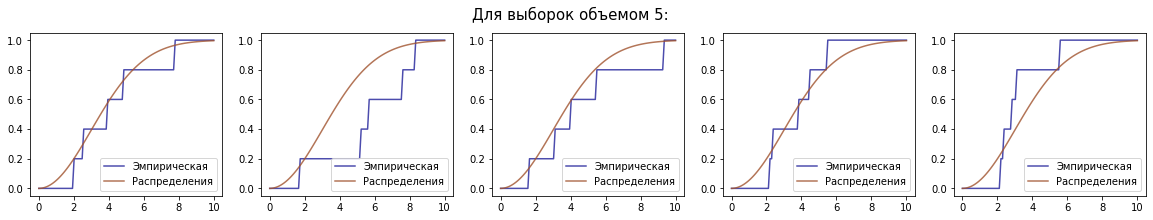

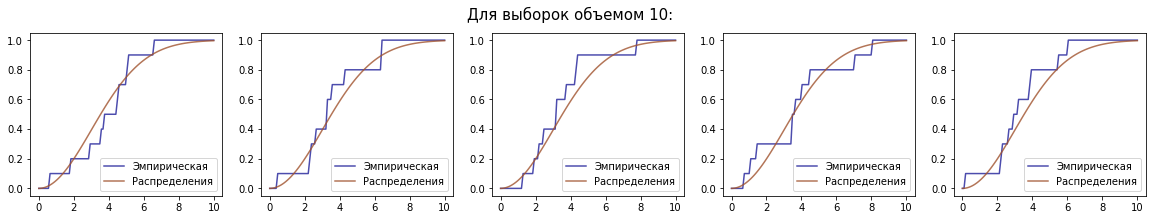

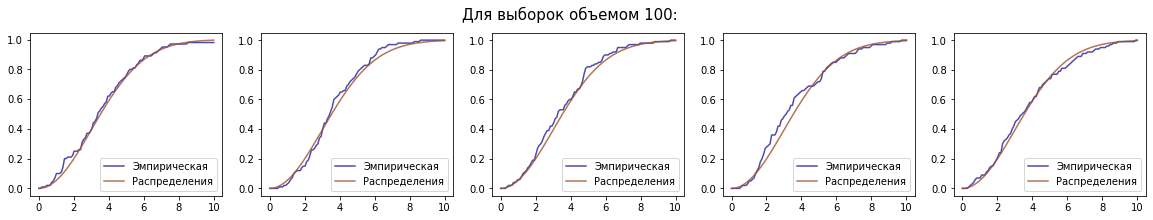

In [68]:
# Эмпирическая функция аналогична объявленной в начале документа

def plots_rayl(rayl, n):
    plt.figure(figsize=(20, 3))
    plt.suptitle('Для выборок объемом ' + str(n) + ':', fontsize=15, y=1.)
    cnt = 151
    for r in rayl:
        xx, yy = emp(r, n, False)
        y_f = list(map(lambda i: F_Rayl(i, 3), xx))
        plt.subplot(cnt)
        plt.plot(xx, yy, alpha = 0.7, color = 'DarkBlue', label = 'Эмпирическая')
        plt.plot(xx, y_f, alpha = 0.8, color = 'Sienna', label = 'Распределения')
        plt.legend(loc="lower right")
        cnt += 1
    
plots_rayl(rayl5, 5)
plots_rayl(rayl10, 10)
plots_rayl(rayl100, 100)

Таким образом, очевидно, что чем больше объем выборки, тем точнее приближение эмпирической функции к функции распределения. Для наглядности представим график для выборки объемом 1000:

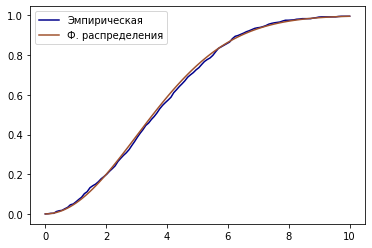

In [70]:
xx, yy = emp(rayl1000[0], 1000, False)
_, ax = plt.subplots()
y_f = list(map(lambda i: F_Rayl(i, 3), xx))
ax.plot(xx, yy, color = 'DarkBlue', label = 'Эмпирическая')
ax.plot(xx, y_f, color = 'Sienna', label = 'Ф. распределения')
ax.legend(loc="upper left")

#### Нахождение точной верхней границы разности каждой пары эмпирических функций распределения.

Берутся два набора x и y, по одному для каждой эмпирической функции для выборке в паре. Точки x, согласно алгоритму нахождения эмпирической функции распределения, для них совпадают. Для каждого x ищутся соответствующие y в каждом из наборов, берется модуль разности для них. Последним шагом ищется максимум этих модулей.

##### 1. Для выборок объемом n = 5

In [71]:
combs5 = list(itertools.combinations(rayl5, 2))
print(high_of_diff(combs5, 5, False))

[0.6 0.2 0.2 0.4 0.4 0.6 0.6 0.2 0.4 0.4]


##### 2. Для выборок объемом n = 10

In [72]:
combs10 = list(itertools.combinations(rayl10, 2))
print(high_of_diff(combs10, 10, False))

[0.3 0.4 0.2 0.3 0.2 0.3 0.2 0.3 0.1 0.3]


##### 3. Для выборок объемом n = 100

In [73]:
combs100 = list(itertools.combinations(rayl100, 2))
print(high_of_diff(combs100, 100, False))

[0.1  0.08 0.1  0.08 0.1  0.14 0.09 0.1  0.08 0.09]


##### 4. Для выборок объемом n = 1000

In [74]:
combs1000 = list(itertools.combinations(rayl1000, 2))
print(high_of_diff(combs1000, 1000, False))

[0.028 0.051 0.031 0.045 0.05  0.041 0.047 0.042 0.028 0.039]


##### 5. Для выборок объемом n = 10 ** 5

In [75]:
combs105 = list(itertools.combinations(rayl105, 2))
print(high_of_diff(combs105, 10 ** 5, False))

[0.00405 0.00168 0.00396 0.00331 0.0045  0.00329 0.00352 0.00283 0.00342
 0.00402]


---
## 2.3 Построение вариационного ряда выборки

In [76]:
var_list_5_R = []
for i in rayl5:
    var_list_5_R.append(sorted(i))
print('Вариационные ряды для выборок объема 5:', *var_list_5_R, sep='\n')
print()

var_list_10_R = []
for i in rayl10:
    var_list_10_R.append(sorted(i))
print('Вариационные ряды для выборок объема 10:', *var_list_10_R, sep='\n')

var_list_100_R = []
for i in rayl100:
    var_list_100_R.append(sorted(i))
    
var_list_1000_R = []
for i in rayl1000:
    var_list_1000_R.append(sorted(i))
    
var_list_105_R = []
for i in rayl105:
    var_list_105_R.append(sorted(i))

Вариационные ряды для выборок объема 5:
[1.978876077959781, 2.5063327221196756, 3.9129663730934054, 4.846721918678741, 7.723719953450479]
[1.6800824734908923, 5.149994191612197, 5.596364317499411, 7.596833899163187, 8.299179225569748]
[1.6242330640981661, 3.035639537749649, 3.958224788094049, 5.4867080909101364, 9.328014527611705]
[2.111565335001899, 2.3049950074025474, 3.811744099616063, 4.480729713830012, 5.504215094865172]
[2.120864262654759, 2.3619428778769755, 2.7554974376381587, 3.0799574992243457, 5.540529948278621]

Вариационные ряды для выборок объема 10:
[0.6161357396178874, 1.7998710871197956, 2.8966926736757226, 3.5647870963252677, 3.6811279250421265, 4.4262862873429505, 4.521883346559514, 5.027137116834488, 5.114306798582081, 6.557225651954404]
[0.39795420038569507, 2.205768465647905, 2.3677646792412177, 2.6226805687625014, 3.225341486394149, 3.2727063944706094, 3.5558960235310053, 4.296679607192729, 6.346673229999161, 6.364127312760802]
[1.270461574691029, 1.8976461156062

#### Найти выборочную квантиль уровня 0.1, 0.5, 0.7

Из функции нахождения эмпирической функции распределения получаем список x и y. Если искомая квантиль находится в списке y, то необходимо найти соответствующую ей x. В противном случае находится промежуток, в котором находится квантиль, и найти среднее в нем.

В случае, если квантиль меньше самого малого из y, возвращается 0.

В случае, если квантиль больше самого большого из у, возвращается x, соответствующее максимальному у.

In [77]:
kv = [0.1, 0.5, 0.7] 

print_quants(kv, rayl5, 5, False)
print()
print_quants(kv, rayl10, 10, False)
print()
print_quants(kv, rayl100, 100, False)
print()
print_quants(kv, rayl1000, 1000, False)
print()
print_quants(kv, pois105, 10 ** 5, False)

Выборки объемом 5:
                    Представленная функция                      Из пакета scipy
0.1    [1.972, 1.697, 1.606, 2.156, 2.156]   [1.979, 1.68, 1.624, 2.112, 2.121]
0.5    [3.899, 5.642, 3.991, 3.807, 2.798]  [3.913, 5.596, 3.958, 3.812, 2.755]
0.7     [4.817, 7.569, 5.459, 4.45, 3.073]   [4.962, 7.625, 5.64, 4.522, 3.178]

Выборки объемом 10:
                    Представленная функция                      Из пакета scipy
0.1    [0.642, 0.459, 1.284, 0.734, 0.183]  [1.113, 1.157, 1.534, 0.869, 0.971]
0.5    [3.761, 3.257, 3.165, 3.486, 2.936]  [4.054, 3.249, 3.162, 3.532, 3.005]
0.7    [4.587, 3.578, 3.761, 4.037, 3.853]  [4.795, 3.956, 4.043, 4.238, 3.858]

Выборки объемом 100:
                    Представленная функция                      Из пакета scipy
0.1     [1.009, 1.376, 1.284, 1.376, 1.33]  [1.095, 1.394, 1.287, 1.379, 1.346]
0.5     [3.349, 3.44, 3.257, 3.119, 3.394]  [3.392, 3.428, 3.238, 3.112, 3.426]
0.7    [4.541, 4.495, 4.633, 4.771, 4.587]   [4.57, 4.479,

---
## 1.4 Построение гистограммы частот

Возьмем отрезок, в который точно попадает вся выборка, и разобьем на N частей. Поставим каждому отрезку в соответствие частное от деления числа чисел из выборки, входящих в отрезок, на объем выборки. По этим данным строится гистограмма.

Wall time: 1 s


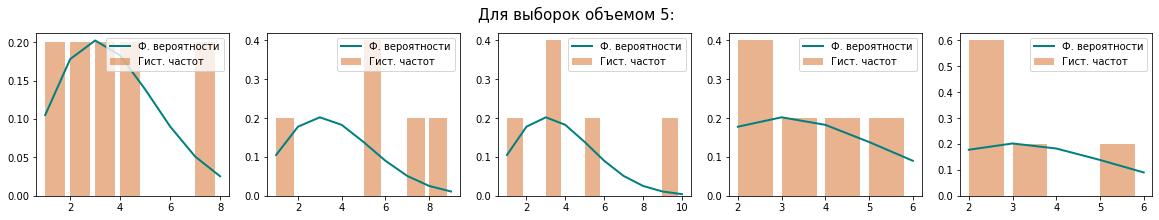

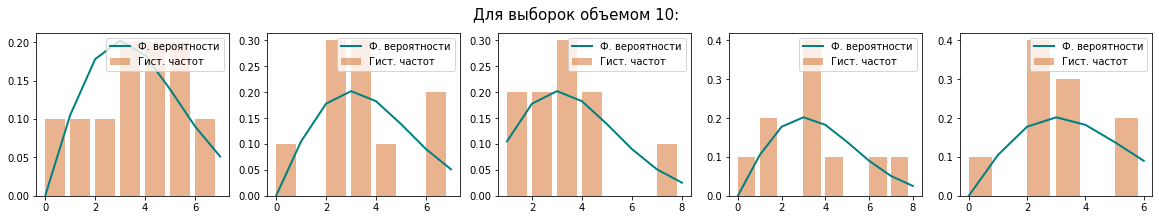

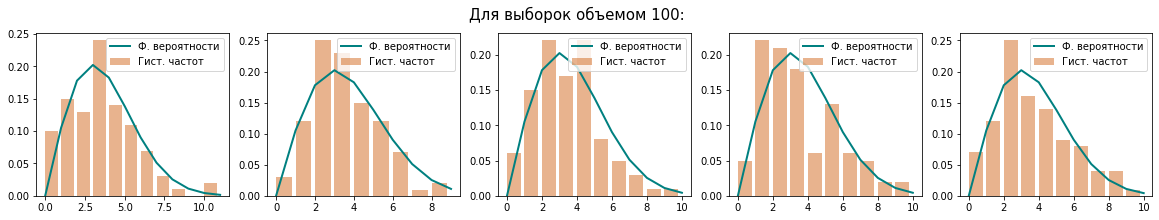

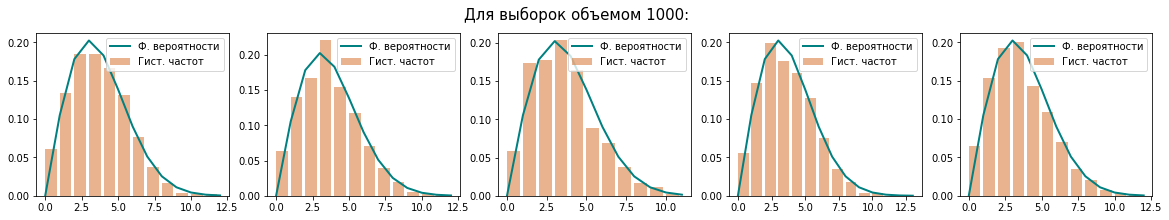

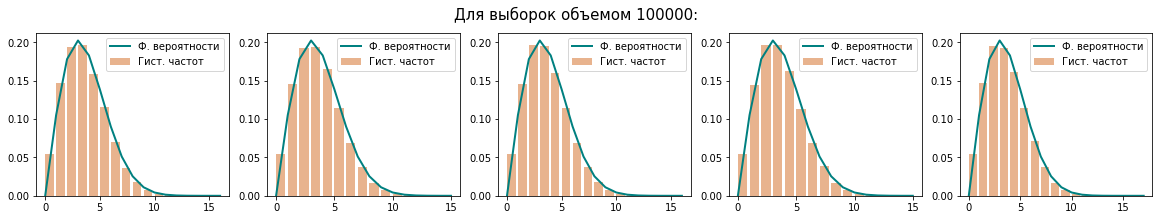

In [144]:
%%time

def freq_hists(var_list, n):
    plt.figure(figsize=(20, 3))
    plt.suptitle('Для выборок объемом ' + str(n) + ':', fontsize=15, y=1.)
    cnt = 151
    for v in var_list:
        vv = list(map(lambda x: int(x), v))
        maximum = max(vv)
        minimum = min(vv)
        xx = list(range(minimum, maximum + 1))
        yy = []
        x_1 = list(range(minimum, maximum + 2))
        y_1 = list(map(lambda x: f_Rayl(x, 3), x_1))
       
        for x in xx:
            yy.append(vv.count(x) / n)
#         print(t2-t1)
        plt.subplot(cnt)
        plt.bar(xx, yy, align='edge', alpha=0.5, color='chocolate', label='Гист. частот')
        plt.plot(x_1, y_1, color='teal', lw=2, label='Ф. вероятности')
        plt.legend(loc="upper right")
        cnt += 1
        
freq_hists(var_list_5_R, 5)
freq_hists(var_list_10_R, 10)
freq_hists(var_list_100_R, 100)
freq_hists(var_list_1000_R, 1000)
freq_hists(var_list_105_R, 10 ** 5)